### We take in the pkl_glucose_info file that contains everything we need: 
### The actual time-series Glucose data, the 6 processed statistics from the time series and the labels (study_group_id)

In [54]:
from model import CNN1DBinaryClassifier,TransformerFusion
from cgm_dataset_transform import GlucoseTransform,CGMDataset
from train_model import train_cgm_classifier
from test_model import do_test
import pandas as pd
import torch.nn as nn
import torch
from torch.utils.data import DataLoader 


In [56]:
pkl_glucose_info = "dataframe_with_glucose_info.pkl"
dfc = pd.read_csv("HbA1c_all_patients.csv")

In [58]:
dataframe_with_glucose_values_diabetes = pd.read_pickle(pkl_glucose_info)
df = dataframe_with_glucose_values_diabetes


df = df[df['patient_ids'].isin(dfc['participant_id'])]

print(df.shape)
# Pick only patients corresponding to prediabetes/life-style controlled diabetes and diabetes with medications.
df = df[df['study_group_id'].isin([1,2])]
df['study_group_id'] = df['study_group_id'] - 1
print(df.shape)

(965, 10)
(511, 10)


In [59]:
df.head()

,patient_ids,Glucose Lists,spike_resolutions,expected_daily_spikes,mean_glucose,relative_spikes,hyper_time_pcts,nocturnal_hypoglycemias,recommended_split,study_group_id
0,1001,"[113, 117, 121, 125, 121, 121, 125, 117, 104, ...",30.131579,3.800000,123.302871,0.391990,8.333333,106.7,train,0
2,1003,"[175, 178, 181, 176, 180, 183, 187, 188, 196, ...",42.166667,3.000000,209.019258,0.444408,93.662465,175.5,train,1
3,1004,"[146, 145, 147, 149, 152, 153, 152, 153, 153, ...",33.859649,5.700000,188.659664,0.407537,90.581232,153.1,val,1
7,1008,"[150, 145, 146, 137, 137, 142, 140, 138, 140, ...",30.757576,3.666667,134.804493,0.422059,21.867322,115.1,train,0
8,1009,"[224, 217, 215, 213, 208, 205, 203, 204, 200, ...",37.903226,3.100000,242.332049,0.634497,91.488616,142.5,val,1


In [60]:
# Split into train val and test, use the recommendations in the AI READI dataset
df_train = df[df['recommended_split'] == 'train']
df_val   = df[df['recommended_split'] == 'val']
df_test  = df[df['recommended_split'] == 'test']
train_df = df_train.reset_index(drop=True)
val_df   = df_val.reset_index(drop=True)
test_df  = df_test.reset_index(drop=True)


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score

col = "study_group_id" 

cols_to_drop = ["patient_ids", "Glucose Lists", "study_group_id","recommended_split"]
X_train =  train_df.drop(columns=cols_to_drop)
y_train = train_df[col]
X_val =  val_df.drop(columns=cols_to_drop)
y_val = val_df[col]
X_test =  test_df.drop(columns=cols_to_drop)
y_test = test_df[col] 
print(X_test.columns)
# Train Random Forest
rf = RandomForestClassifier(n_estimators=128, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]  # Probability for class 1

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {auc:.4f}")

Index(['spike_resolutions', 'expected_daily_spikes', 'mean_glucose',
       'relative_spikes', 'hyper_time_pcts', 'nocturnal_hypoglycemias'],
      dtype='object')
Accuracy: 0.7432432432432432
Confusion Matrix:
 [[21 14]
 [ 5 34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.60      0.69        35
           1       0.71      0.87      0.78        39

    accuracy                           0.74        74
   macro avg       0.76      0.74      0.74        74
weighted avg       0.76      0.74      0.74        74

ROC AUC Score: 0.7560


Original shape: (288,)


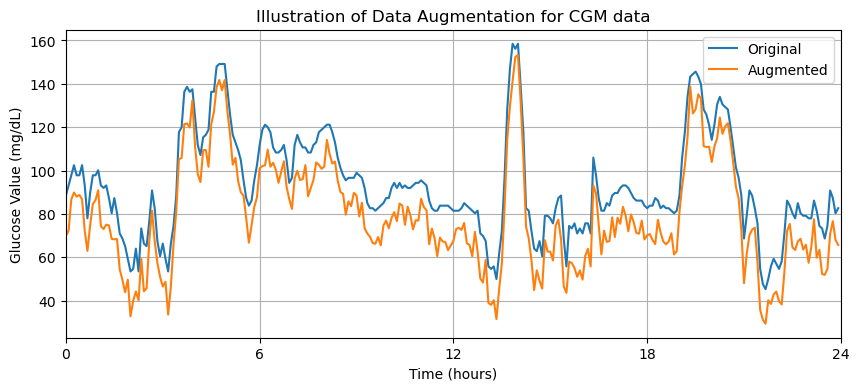

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Original dataset (no transform)
dataset = CGMDataset(train_df, seq_col='Glucose Lists', label_col=col, offset=0, mode=0, transform=None)

x_orig = dataset[0][0].squeeze().numpy()  
x_orig = x_orig * 140 + 120   # rescale
print("Original shape:", x_orig.shape)

# Create time axis in hours (288 * 5min = 1440min = 24h)
time_axis = np.arange(len(x_orig)) * 5 / 60.0  # hours

plt.figure(figsize=(10,4))
plt.plot(time_axis, x_orig, label="Original")

# Dataset with transform
transform = GlucoseTransform(add_range=(-0.1,0.1),
                             alpha_range=(0.9,1.1),
                             noise_range=(-0.05,0.05))

dataset_aug = CGMDataset(train_df, seq_col='Glucose Lists', label_col=col, offset=0, mode=0, transform=transform)

x_aug = dataset_aug[0][0].squeeze().numpy()
x_aug = x_aug * 140 + 120

plt.plot(time_axis, x_aug, label="Augmented")

# Formatting
plt.title("Illustration of Data Augmentation for CGM data")
plt.xlabel("Time (hours)")
plt.ylabel("Glucose Value (mg/dL)")
plt.xlim(0, 24)                     # force axis from 0 to 24
plt.xticks(np.arange(0, 25, 6))     # ticks every 6 hours
plt.legend()
plt.grid(True)
plt.show()


In [63]:
#train on entire week of data and test

label_col = col
print(col)
print(train_df.columns)
transform = GlucoseTransform(add_range=(-0.1,0.1), alpha_range =(0.9,1.1), noise_range=(-0.05,0.05))

dataset  = CGMDataset(train_df, seq_col='Glucose Lists', label_col=col, offset=0, mode = 1, transform = transform)
loader   = DataLoader(dataset, batch_size=32, shuffle=True)
val_dataset = CGMDataset(val_df, seq_col='Glucose Lists', label_col=col,offset=0,  mode = 1)
val_dataloader  = DataLoader(val_dataset, batch_size=32,shuffle=False)
model    = CNN1DBinaryClassifier(num_classes=2)

probs  = train_cgm_classifier(
        loader,val_dataloader, model,
        epochs=30,
        lr=1e-4,
        mode = 1
    )
prob_list = []
labels_list = []

model = CNN1DBinaryClassifier()
state_dict = torch.load("best_model_a1c1.pth")
model.load_state_dict(state_dict) 
model.to("cuda")

test_dataset = CGMDataset(test_df, seq_col='Glucose Lists',
                          label_col=col,
                          offset=0, mode=1)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
probs, labels, loss = do_test(model, test_loader, criterion =nn.CrossEntropyLoss())
auc = roc_auc_score(labels, np.array(probs)[:,1])
print("Per week deep learning model",auc)



study_group_id
Index(['patient_ids', 'Glucose Lists', 'spike_resolutions',
       'expected_daily_spikes', 'mean_glucose', 'relative_spikes',
       'hyper_time_pcts', 'nocturnal_hypoglycemias', 'recommended_split',
       'study_group_id'],
      dtype='object')
Total params:      3,058,370
Trainable params:  3,058,370
Epoch 1/30 — Loss: 0.6859 — Accuracy: 0.5882 - Val Loss: 0.6896
Best Val Loss 0.6895621538162231
Epoch 2/30 — Loss: 0.6663 — Accuracy: 0.5882 - Val Loss: 0.6998
Epoch 3/30 — Loss: 0.6701 — Accuracy: 0.5882 - Val Loss: 0.6760
Best Val Loss 0.6759737849235534
Epoch 4/30 — Loss: 0.6470 — Accuracy: 0.5882 - Val Loss: 0.6669
Best Val Loss 0.6669487714767456
Epoch 5/30 — Loss: 0.6310 — Accuracy: 0.5882 - Val Loss: 0.6653
Best Val Loss 0.6652951836585999
Epoch 6/30 — Loss: 0.6307 — Accuracy: 0.6106 - Val Loss: 0.6619
Best Val Loss 0.6618919014930725
Epoch 7/30 — Loss: 0.6186 — Accuracy: 0.6527 - Val Loss: 0.6572
Best Val Loss 0.6571955204010009
Epoch 8/30 — Loss: 0.6179 — Accu

In [64]:
# First train classifier to take in one day of data and predict the output class
# Then compute probabilities by feeding each day of data at a time
# Take the max of the probabilities to determine final classification probability.

label_col = col
print(col)
print(train_df.columns)
transform = GlucoseTransform(add_range=(-0.1,0.1), alpha_range =(0.9,1.1), noise_range=(-0.05,0.05))

dataset  = CGMDataset(train_df, seq_col='Glucose Lists', label_col=col, offset=0, mode = 0, transform = transform)
loader   = DataLoader(dataset, batch_size=32, shuffle=True)
val_dataset = CGMDataset(val_df, seq_col='Glucose Lists', label_col=col,offset=0,  mode = 0)
val_dataloader  = DataLoader(val_dataset, batch_size=32,shuffle=False)

model    = CNN1DBinaryClassifier(num_classes=2)

probs  = train_cgm_classifier(
        loader,val_dataloader, model,
        epochs=30,
        lr=1e-4,
        mode =0
    )


prob_list = []
labels_list = []
print(col)
model = CNN1DBinaryClassifier(num_classes=2)
state_dict = torch.load("best_model_a1c0.pth")
model.load_state_dict(state_dict) 
model.to("cuda")
model.eval()
for i in range(7):
    test_dataset = CGMDataset(test_df, seq_col='Glucose Lists',
                              label_col=col,
                              offset=i, mode=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    probs, labels, loss = do_test(model, test_loader, criterion =nn.CrossEntropyLoss())
    
    prob_list.append(probs)   # Shape: (num_patients,) → each day = row
    labels_list.append(labels)  # Same shape

import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve

# prob_list and labels_list are currently lists of arrays (len = 7)
# Stack them: shape (7, N) where N = number of patients
probs_all = np.stack(prob_list, axis=0)       # shape: (7, N, 2) if probs are softmax for both classes
labels_all = np.stack(labels_list, axis=0)    # shape: (7, N)


# If probs are 2D (N,2), we need column 1
if probs_all.ndim == 3:
    probs_all = probs_all[..., 1]   # shape (7, N)


probs_max = probs_all.max(axis=0)   # shape (N,)


# All days should have the same labels, so just take the first
labels = labels_all[0]              # shape (N,)

auc = roc_auc_score(labels, probs_max)
fpr, tpr, thresholds = roc_curve(labels, probs_max)

print("Max pooling across daily probs ROC AUC:", auc)

study_group_id
Index(['patient_ids', 'Glucose Lists', 'spike_resolutions',
       'expected_daily_spikes', 'mean_glucose', 'relative_spikes',
       'hyper_time_pcts', 'nocturnal_hypoglycemias', 'recommended_split',
       'study_group_id'],
      dtype='object')
Total params:      3,058,370
Trainable params:  3,058,370
Epoch 1/30 — Loss: 0.6545 — Accuracy: 0.5870 - Val Loss: 0.6613
Best Val Loss 0.6612691504614694
Epoch 2/30 — Loss: 0.6277 — Accuracy: 0.6403 - Val Loss: 0.6646
Epoch 3/30 — Loss: 0.6230 — Accuracy: 0.6611 - Val Loss: 0.6519
Best Val Loss 0.6518511550767081
Epoch 4/30 — Loss: 0.6163 — Accuracy: 0.6583 - Val Loss: 0.6477
Best Val Loss 0.6477089013372149
Epoch 5/30 — Loss: 0.6077 — Accuracy: 0.6539 - Val Loss: 0.6344
Best Val Loss 0.6343647786549159
Epoch 6/30 — Loss: 0.6048 — Accuracy: 0.6503 - Val Loss: 0.6233
Best Val Loss 0.6233176333563668
Epoch 7/30 — Loss: 0.5988 — Accuracy: 0.6599 - Val Loss: 0.6184
Best Val Loss 0.6183502163205828
Epoch 8/30 — Loss: 0.5980 — Accu

## Next step use a transformer to fuse embeddings per day. The model is initialized with the pre-trained weights


        

In [65]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN1DBinaryClassifier(num_classes=2)

cnn_model.load_state_dict(torch.load('best_model_a1c0.pth'))


fusion_model = TransformerFusion(cnn_model)
fusion_model = fusion_model.to(device)

transform = GlucoseTransform(add_range=(-0.2,0.2), alpha_range =(0.8,1.2), noise_range=(-0.1,0.1))

dataset  = CGMDataset(train_df, seq_col='Glucose Lists', label_col=col, offset=0, mode = 1, transform=transform)
loader   = DataLoader(dataset, batch_size=32, shuffle=True)
val_dataset = CGMDataset(val_df, seq_col='Glucose Lists', label_col=col,offset=0,  mode = 1)
val_dataloader  = DataLoader(val_dataset, batch_size=32,shuffle=False)
test_dataset = CGMDataset(test_df, seq_col='Glucose Lists', label_col=col,offset=0,  mode = 1)
test_dataloader  = DataLoader(test_dataset, batch_size=32,shuffle=False)


probs  = train_cgm_classifier(
        loader,val_dataloader, fusion_model,
        epochs=30,
        lr=1e-5,
        mode=1
    )

Sequential(
  (0): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (1): ReLU()
  (2): Conv1d(32, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (3): ReLU()
  (4): Conv1d(64, 128, kernel_size=(7,), stride=(2,), padding=(3,))
  (5): ReLU()
  (6): Conv1d(128, 256, kernel_size=(7,), stride=(2,), padding=(3,))
  (7): ReLU()
  (8): Conv1d(256, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (9): ReLU()
  (10): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (11): ReLU()
  (12): Conv1d(512, 1024, kernel_size=(3,), stride=(2,), padding=(1,))
  (13): ReLU()
  (14): AdaptiveAvgPool1d(output_size=1)
)
Total params:      9,639,620
Trainable params:  9,639,620
Epoch 1/30 — Loss: 0.6085 — Accuracy: 0.6751 - Val Loss: 0.6275
Best Val Loss 0.6275463342666626
Epoch 2/30 — Loss: 0.5793 — Accuracy: 0.6975 - Val Loss: 0.6036
Best Val Loss 0.6035725355148316
Epoch 3/30 — Loss: 0.5499 — Accuracy: 0.7171 - Val Loss: 0.6059
Epoch 4/30 — Loss: 0.5562 — Accuracy: 0.6639 - Va

In [66]:

#Finally get the test results
prob_list = []
labels_list = []

fusion_model = TransformerFusion(cnn_model)
fusion_model = fusion_model.to(device)

fusion_model.load_state_dict(torch.load("best_model_a1c1.pth"))

fusion_model.to("cuda")
fusion_model.eval()

test_dataset = CGMDataset(test_df, seq_col='Glucose Lists',
                          label_col=col,
                          offset=0, mode=1)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
probs, labels, loss  = do_test(fusion_model, test_loader, criterion =nn.CrossEntropyLoss())
probs = np.concatenate(probs, axis=0)
auc = roc_auc_score(labels, probs[1::2])
print(auc)


Sequential(
  (0): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (1): ReLU()
  (2): Conv1d(32, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (3): ReLU()
  (4): Conv1d(64, 128, kernel_size=(7,), stride=(2,), padding=(3,))
  (5): ReLU()
  (6): Conv1d(128, 256, kernel_size=(7,), stride=(2,), padding=(3,))
  (7): ReLU()
  (8): Conv1d(256, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (9): ReLU()
  (10): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (11): ReLU()
  (12): Conv1d(512, 1024, kernel_size=(3,), stride=(2,), padding=(1,))
  (13): ReLU()
  (14): AdaptiveAvgPool1d(output_size=1)
)
0.8219780219780219
Threshold: 0.5
Confusion Matrix:
 [[33  2]
 [18 21]]


In [67]:
#XGBoost + PCA
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
X_train = dataset.X.squeeze()
y_train = dataset.y
print(X_train.shape)
X_val = val_dataset.X.squeeze()
y_val = val_dataset.y
X_test = test_dataset.X.squeeze()
y_test = test_dataset.y

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.99)),  
    ("xgb", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42,
        use_label_encoder=False
    ))
])


pipeline.fit(X_train, y_train)


y_val_pred = pipeline.predict(X_val)
y_val_prob = pipeline.predict_proba(X_val)[:, 1]

print("Validation AUC:", roc_auc_score(y_val, y_val_prob))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

y_test_pred = pipeline.predict(X_test)
y_test_prob = pipeline.predict_proba(X_test)[:, 1]

print("Test AUC:", roc_auc_score(y_test, y_test_prob))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


torch.Size([357, 2016])


C:\ProgramData\Anaconda3\envs\aireadi\lib\site-packages\xgboost\training.py:183: UserWarning: [21:58:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation AUC: 0.6535087719298246
Validation Accuracy: 0.6375
Validation Confusion Matrix:
 [[26 12]
 [17 25]]
Test AUC: 0.7113553113553114
Test Accuracy: 0.6891891891891891
Test Confusion Matrix:
 [[22 13]
 [10 29]]


In [68]:
# TABFPN with PCA
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import torch
from tabpfn import TabPFNClassifier

X_train = dataset.X.squeeze()
y_train = dataset.y
print(X_train.shape)
X_val = val_dataset.X.squeeze()
y_val = val_dataset.y
X_test = test_dataset.X.squeeze()
y_test = test_dataset.y


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Explained variance ratio (50 PCs):", pca.explained_variance_ratio_.sum())


clf = TabPFNClassifier(
    device="cuda" if torch.cuda.is_available() else "cpu"
)

clf.fit(X_train_pca, y_train)


y_val_pred = clf.predict(X_val_pca)
y_val_prob = clf.predict_proba(X_val_pca)[:, 1]

print("\nValidation Metrics")
print(" AUC:", roc_auc_score(y_val, y_val_prob))
print(" Accuracy:", accuracy_score(y_val, y_val_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))


y_test_pred = clf.predict(X_test_pca)
y_test_prob = clf.predict_proba(X_test_pca)[:, 1]

print("\nTest Metrics")
print(" AUC:", roc_auc_score(y_test, y_test_prob))
print(" Accuracy:", accuracy_score(y_test, y_test_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


torch.Size([357, 2016])
Explained variance ratio (50 PCs): 0.9901615533640618


C:\ProgramData\Anaconda3\envs\aireadi\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Validation Metrics
 AUC: 0.6525689223057644
 Accuracy: 0.625
 Confusion Matrix:
 [[27 11]
 [19 23]]

Test Metrics
 AUC: 0.7578754578754578
 Accuracy: 0.6891891891891891
 Confusion Matrix:
 [[24 11]
 [12 27]]
